# **1. Configuración del ambiente**

In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import zipfile
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import linear_kernel
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)


# **2. Obtención de datos**

In [329]:
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  3755k      0 --:--:-- --:--:-- --:--:-- 3746k


In [330]:
#Creamos una copia de los dataframes
df_movies = pd.read_csv('/content/data/ml-latest-small/movies.csv')
df_ratings = pd.read_csv('/content/data/ml-latest-small/ratings.csv')

In [331]:
!curl http://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('data')
global df_movies_copy, df_ratings_copy, df_final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  6114k      0 --:--:-- --:--:-- --:--:-- 6123k


In [332]:
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [333]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [334]:
df_movies.shape

(9742, 3)

In [335]:
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.00,964982703
1,1,3,4.00,964981247
2,1,6,4.00,964982224
3,1,47,5.00,964983815
4,1,50,5.00,964982931


In [336]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [337]:
df_ratings.shape

(100836, 4)

In [338]:
#Hacemos copia de los dataframes
df_movies_copy = df_movies.copy()
df_ratings_copy = df_ratings.copy()


# **3. Tratamiento de los datos**

## Datos nulos

In [339]:
df_movies_copy.isna().sum()

,0
movieId,0
title,0
genres,0


In [340]:
df_ratings_copy.isna().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


In [341]:
df_movies_copy.shape

(9742, 3)

In [342]:
df_movies_copy.dropna(inplace=True)
df_movies_copy.shape

(9742, 3)

In [343]:
df_ratings_copy.shape

(100836, 4)

In [344]:
df_ratings_copy.dropna(inplace=True)
df_ratings_copy.shape

(100836, 4)

In [345]:
df_movies_copy.drop_duplicates(subset='movieId',keep='first', inplace=True)
df_movies_copy.shape

(9742, 3)

In [346]:
df_ratings_copy.drop_duplicates(subset=['movieId','userId'],keep='first', inplace=True)
df_ratings_copy.shape

(100836, 4)

In [347]:
df_movies_copy['content'] = df_movies_copy['genres'].str.replace('|', ' ')
df_movies_copy.head(5)

,movieId,title,genres,content
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,Comedy


In [348]:
df_movies_copy['genre_set'] = df_movies_copy['genres'].apply(lambda x: ', '.join(sorted(set(x.split('|')))))
df_movies_copy.head(5)

,movieId,title,genres,content,genre_set
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure Children Fantasy,"Adventure, Children, Fantasy"
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy Romance,"Comedy, Romance"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy Drama Romance,"Comedy, Drama, Romance"
4,5,Father of the Bride Part II (1995),Comedy,Comedy,Comedy


In [349]:
df_movies_copy.dtypes

,0
movieId,int64
title,object
genres,object
content,object
genre_set,object


In [350]:
df_ratings_copy.dtypes


,0
userId,int64
movieId,int64
rating,float64
timestamp,int64


In [351]:
df_ratings_copy['timestamp'] = pd.to_datetime(df_ratings_copy['timestamp'], unit='s').dt.normalize()
df_ratings_copy.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.00,2000-07-30
1,1,3,4.00,2000-07-30
2,1,6,4.00,2000-07-30
3,1,47,5.00,2000-07-30
4,1,50,5.00,2000-07-30


In [352]:
df_ratings_copy.dtypes

,0
userId,int64
movieId,int64
rating,float64
timestamp,datetime64[ns]


In [353]:
def preprocesamiento():
    global df_movies_copy, df_ratings_copy
    df_movies_copy.dropna(inplace=True)
    df_ratings_copy.dropna(inplace=True)
    df_movies_copy.drop_duplicates(subset='movieId',keep='first', inplace=True)
    df_ratings_copy.drop_duplicates(subset=['movieId','userId'],keep='first', inplace=True)
    df_movies_copy['content'] = df_movies_copy['genres'].str.replace('|', ' ')
    df_movies_copy['genre_set'] = df_movies_copy['genres'].apply(lambda x: ', '.join(sorted(set(x.split('|')))))
    df_ratings_copy['timestamp'] = pd.to_datetime(df_ratings_copy['timestamp'], unit='s').dt.normalize()
    return df_movies_copy, df_ratings_copy

# **4. Análisis Exploratorio (EDA)**

In [354]:
df_movies_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   movieId    9742 non-null   int64 
 1   title      9742 non-null   object
 2   genres     9742 non-null   object
 3   content    9742 non-null   object
 4   genre_set  9742 non-null   object
dtypes: int64(1), object(4)
memory usage: 380.7+ KB


In [355]:
df_movies_copy.describe()

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [356]:
df_ratings_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


In [357]:
df_ratings_copy.describe()

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,100836
mean,326.13,19435.30,3.50,2008-03-19 03:54:37.829346560
min,1.00,1.00,0.50,1996-03-29 00:00:00
25%,177.00,1199.00,3.00,2002-04-18 00:00:00
50%,325.00,2991.00,3.50,2007-08-02 00:00:00
75%,477.00,8122.00,4.00,2015-07-04 00:00:00
max,610.00,193609.00,5.00,2018-09-24 00:00:00
std,182.62,35530.99,1.04,NaN


### Histograma de Ratings

Creamos un histograma para ver las distribución de las calificaciones que han dado los usuarios a las películas.

In [358]:
# Vemos el total de calificaciones por cada puntuación
df_ratings_copy['rating'].value_counts()

,count
rating,
4.00,26818
3.00,20047
5.00,13211
3.50,13136
4.50,8551
2.00,7551
2.50,5550
1.00,2811
1.50,1791


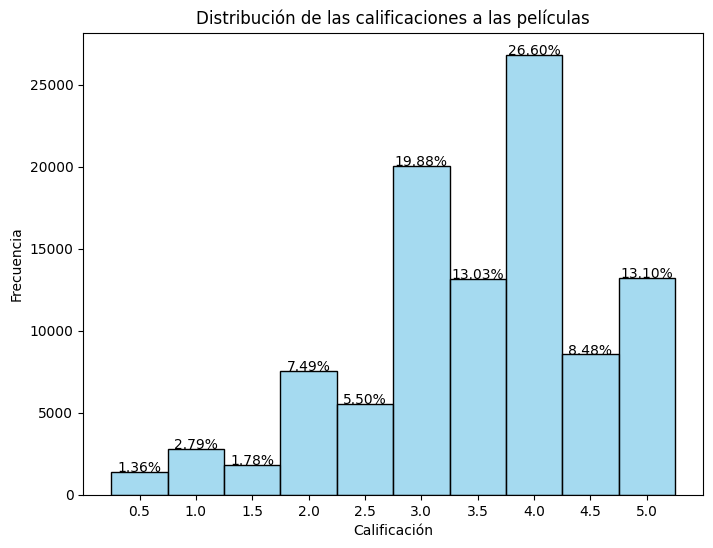

In [359]:
plt.figure(figsize=(8, 6))
bin_edges = np.arange(0.25, 5.75, 0.5)
# Creamos el histograma
ax = sns.histplot(df_ratings_copy['rating'], bins=bin_edges, kde=False, color='skyblue', edgecolor='black')

# Calculamos el número total de calificaciones
total_ratings = df_ratings_copy['rating'].count()

# Agregamos el porcentaje a cada barra
for p in ax.patches:
    height = p.get_height()
    percentage = f'{(height / total_ratings) * 100:.2f}%'  # Calculate percentage
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, percentage, ha="center")

# Creamos las etiquetas para cada valor de calificación
ax.set_xticks(np.arange(0.5, 5.5, 0.5))

# Agregamos encabezados al titulo y a los ejes
plt.title('Distribución de las calificaciones a las películas')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')

# Show plot
plt.show()


###Histograma de calificaciones por año
Para entender como han calificado los usuarios a las películas a traves de los años , primero veremos las distribuciones totales de las calificaciones

Para entender mejor el histograma agruparemos las calificaciones entre 1 y 5 sin considerar los números flotantes

In [360]:
# Creamos una función para categorizar
def categorizar_rating(rating):
    if rating <= 1.5:
        return 1
    elif rating <= 2.5:
        return 2
    elif rating <= 3.5:
        return 3
    elif rating <= 4.5:
        return 4
    else:
        return 5

In [361]:
# Ahora lo aplicamos a la columna rating
df_ratings_copy['rating_categoria'] = df_ratings_copy['rating'].apply(categorizar_rating)
df_ratings_copy.head(5)

,userId,movieId,rating,timestamp,rating_categoria
0,1,1,4.00,2000-07-30,4
1,1,3,4.00,2000-07-30,4
2,1,6,4.00,2000-07-30,4
3,1,47,5.00,2000-07-30,5
4,1,50,5.00,2000-07-30,5


In [362]:
df_ratings_copy['rating_categoria'].value_counts()

,count
rating_categoria,
4,35369
3,33183
5,13211
2,13101
1,5972


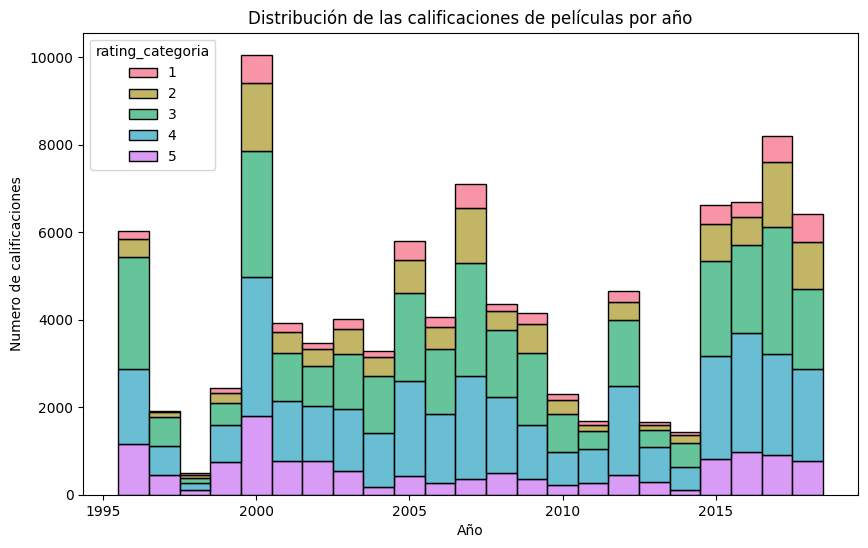

In [363]:
# Extraemos el año desde la columna timestamp
df_ratings_copy['year'] = pd.to_datetime(df_ratings_copy['timestamp']).dt.year
# Elegimos el color de la paleta a usar
colors = sns.color_palette("husl", 5)
# Creamos el histograma
plt.figure(figsize=(10, 6))
sns.histplot(df_ratings_copy, x='year', hue='rating_categoria', multiple='stack', bins=20,palette=colors, discrete=True)
plt.title('Distribución de las calificaciones de películas por año')
plt.xlabel('Año')
plt.ylabel('Numero de calificaciones')
plt.show()

###Gráfico de barras de popularidad de generos basada en las calificaciones
Para mostrar la popularidad de cada genero entre los usuarios basado en el número de calificaciones.

<ipython-input-364-aceea5e5a28b>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, genre_counts[i] + 0.4, f'{genre_percentages[i]:.1f}%', ha='center')


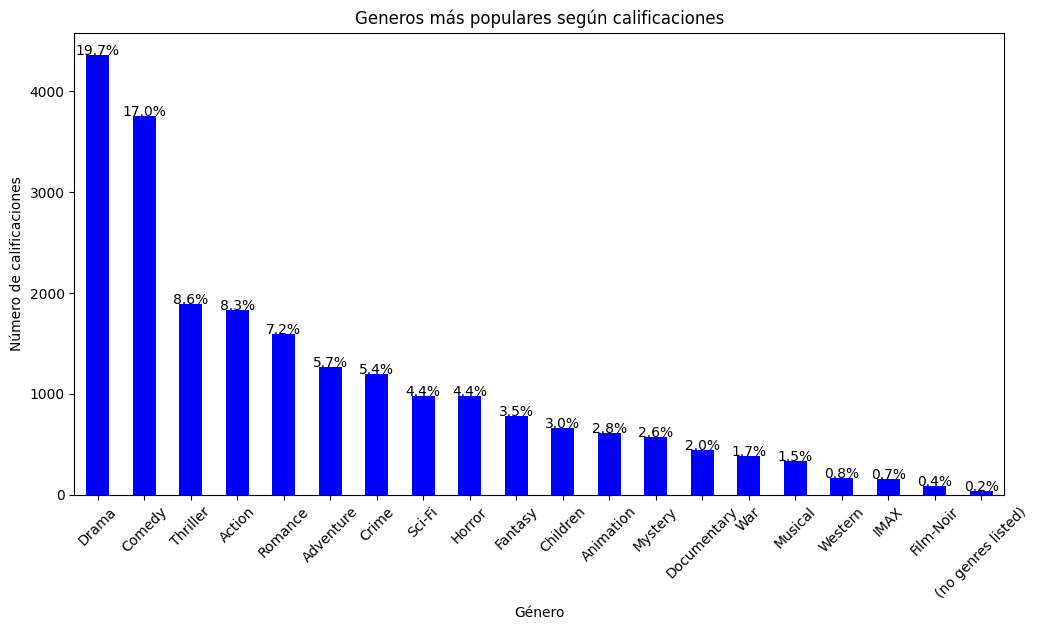

In [364]:
genre_counts = df_movies_copy['genre_set'].str.get_dummies(', ').sum().sort_values(ascending=False)
total_ratings = genre_counts.sum()
genre_percentages = (genre_counts / total_ratings) * 100

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = genre_counts.plot(kind='bar', color='blue')

# Annotate each bar with the percentage
for i in range(len(genre_counts)):
    plt.text(i, genre_counts[i] + 0.4, f'{genre_percentages[i]:.1f}%', ha='center')

# Title and labels
plt.title('Generos más populares según calificaciones')
plt.xlabel('Género')
plt.ylabel('Número de calificaciones')
plt.xticks(rotation=45)
plt.show()

###Creamos el df_final uniendo los dos datasets:


In [365]:
df_final = pd.merge(df_ratings_copy, df_movies_copy, on='movieId')
df_final.head(5)

,userId,movieId,rating,timestamp,rating_categoria,year,title,genres,content,genre_set
0,1,1,4.00,2000-07-30,4,2000,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
1,5,1,4.00,1996-11-08,4,1996,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
2,7,1,4.50,2005-01-25,4,2005,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
3,15,1,2.50,2017-11-13,2,2017,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
4,17,1,4.50,2011-05-18,4,2011,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"


In [366]:
df_final.drop(columns=['rating_categoria'], inplace=True)
df_final.head(5)

,userId,movieId,rating,timestamp,year,title,genres,content,genre_set
0,1,1,4.00,2000-07-30,2000,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
1,5,1,4.00,1996-11-08,1996,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
2,7,1,4.50,2005-01-25,2005,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
3,15,1,2.50,2017-11-13,2017,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"
4,17,1,4.50,2011-05-18,2011,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure Animation Children Comedy Fantasy,"Adventure, Animation, Children, Comedy, Fantasy"


In [367]:
df_final.shape

(100836, 9)

In [368]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
 4   year       100836 non-null  int32         
 5   title      100836 non-null  object        
 6   genres     100836 non-null  object        
 7   content    100836 non-null  object        
 8   genre_set  100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(4)
memory usage: 6.5+ MB


# **5. Recomendación no personalizada**





### 5.1 Recomendación basada en filtrar las películas que tienen más de 210 votos

In [369]:
def recomendaciones_populares(df):
  global df_movies_copy, df_ratings_copy, df_final
  count_rating = df.title.value_counts()
  popular_movie = count_rating[count_rating > 210].index
  df_popular_movies = df[df['title'].isin(popular_movie)]
  average_rating = df_popular_movies.groupby('title')['rating'].mean()
  df_movie_stats = pd.DataFrame({
        'mean_rating': average_rating,
        'vote_count': df_popular_movies['title'].value_counts(),
    })
  df_movie_stats_reset = df_movie_stats.reset_index()
  df_merged = pd.merge(df_popular_movies[['movieId', 'title']], df_movie_stats_reset, on='title', how='inner').drop_duplicates(subset=['title'])
  top_movies = df_merged.sort_values(by=['mean_rating'], ascending=False).head(10)
  print('Las 10 películas más populares son:  ')

  return top_movies

recomendaciones_populares(df_final)

Las 10 películas más populares son:  


,movieId,title,mean_rating,vote_count
2783,318,"Shawshank Redemption, The (1994)",4.43,317
2565,2959,Fight Club (1999),4.27,218
452,260,Star Wars: Episode IV - A New Hope (1977),4.23,251
1577,527,Schindler's List (1993),4.22,220
2076,1196,Star Wars: Episode V - The Empire Strikes Back...,4.22,211
703,296,Pulp Fiction (1994),4.20,307
2287,2571,"Matrix, The (1999)",4.19,278
1010,356,Forrest Gump (1994),4.16,329
1797,593,"Silence of the Lambs, The (1991)",4.16,279
215,110,Braveheart (1995),4.03,237


### 5.2 Recomendación basada en una adaptación de una métrica estadística llamada promedio bayesiano.

In [370]:
def recomendaciones_populares(df):
  global df_movies_copy, df_ratings_copy, df_final
  average_rating = df.groupby('title')['rating'].mean() # Promedio de calificación por película
  vote_count = df['title'].value_counts() # Número de votos por película
  C = df['rating'].mean()  # Media de las calificaciones global
  m = vote_count.quantile(0.90) # Número mínimo de votos por película,percentil 90
  # Fórmula del promedio bayesiano
  w1 = vote_count/(vote_count + m)
  w2 = m/(vote_count + m)
  bayesian_scores = ( w1 * average_rating) + (w2 * C)
  # Creamos el dataframe con las columnas
  df_movie_stats = pd.DataFrame({
        'mean_rating': average_rating,
        'vote_count': vote_count,
        'weighted_score': bayesian_scores
    })
  df_movie_stats_reset = df_movie_stats.reset_index()
  df_merged = pd.merge(df[['movieId', 'title']], df_movie_stats_reset, on='title', how='inner').drop_duplicates(subset=['title'])
  top_movies = df_merged.sort_values(by=['weighted_score'], ascending=False).head(10)

  print('Las 10 películas más populares son:  ')

  return top_movies

recomendaciones_populares(df_final)

Las 10 películas más populares son:  


,movieId,title,mean_rating,vote_count,weighted_score
16296,318,"Shawshank Redemption, The (1994)",4.43,317,4.36
45361,858,"Godfather, The (1972)",4.29,192,4.19
14323,2959,Fight Club (1999),4.27,218,4.19
1568,260,Star Wars: Episode IV - A New Hope (1977),4.23,251,4.16
572,50,"Usual Suspects, The (1995)",4.24,204,4.15
3570,527,Schindler's List (1993),4.22,220,4.15
1819,296,Pulp Fiction (1994),4.20,307,4.14
6777,1196,Star Wars: Episode V - The Empire Strikes Back...,4.22,211,4.13
12642,2571,"Matrix, The (1999)",4.19,278,4.13
50528,1221,"Godfather: Part II, The (1974)",4.26,129,4.13


# **6. Recomendación personalizada: Content-based**

### 6.1 Similitud de Coseno:




In [371]:
df_movies_copy['content'].head(10)

,content
0,Adventure Animation Children Comedy Fantasy
1,Adventure Children Fantasy
2,Comedy Romance
3,Comedy Drama Romance
4,Comedy
5,Action Crime Thriller
6,Comedy Romance
7,Adventure Children
8,Action
9,Action Adventure Thriller


In [372]:
df_movies_copy['content'].tail(10)

,content
9732,Action Animation Comedy Sci-Fi
9733,Animation Drama
9734,Comedy Drama
9735,Animation
9736,Documentary
9737,Action Animation Comedy Fantasy
9738,Animation Comedy Fantasy
9739,Drama
9740,Action Animation
9741,Comedy


In [373]:
# Configurar el TfidfVectorizer con parámetros ajustados
tfidf_vectorizer = TfidfVectorizer(stop_words='english') #max_df=0.7, min_df=2)

# Calcular la matriz TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_movies_copy['content'])


In [374]:
# Verificamos el tipo de dato de la matriz TF-IDF
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [375]:
tfidf_matrix.shape

(9742, 23)

In [376]:
# Calcular la matriz de similitud coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [377]:
# Elaboramos una lista donde comparamos la película Toy Story(movieId=1)con el resto de películas y muestra la distancia con cada una
idx = 0  # índice de la película Toy Story
sim_scores = list(enumerate(cosine_sim[idx]))
# Ordenamos la lista poniendo la columna de distancia(x[1]) en orden descendente, la de mayor similitud primero
sim_scores.sort(key=lambda x: x[1], reverse=True)
# Elegimos los 10 primeros índices de la lista, quitando el O por que es la misma película
sim_scores = sim_scores[1:11]
sim_scores

[(1706, 0.9999999999999998),
 (2355, 0.9999999999999998),
 (2809, 0.9999999999999998),
 (3000, 0.9999999999999998),
 (3568, 0.9999999999999998),
 (6194, 0.9999999999999998),
 (6486, 0.9999999999999998),
 (6948, 0.9999999999999998),
 (7760, 0.9999999999999998),
 (8219, 0.9999999999999998)]

Para crear la función usaremos como parametros el índice que ordena secuencialmente todas las películas del dataframe *df_movie_copy* que también será un parametro, la matriz de similitud coseno y finalmente el número de recomendaciones (10) que daremos al usuario.

In [378]:
def recomendacion_tf_idf(index,df,cosine_sim, n_recommendations=10):
    # Paso 1: Obtener el índice de la película
    idx = index

    # Paso 2: Obtener las puntuaciones de similitud coseno para todas las películas respecto a la película dada
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Paso 3: Ordenar las películas por las puntuaciones de similitud en orden descendente
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Paso 4: Filtrar o eliminar la película de entrada para que no se recomiende a sí misma
    sim_scores = sim_scores[1:]

    # Paso 5: Obtener los índices de las n_recommendations películas más similares
    movie_indices = [i[0] for i in sim_scores[:n_recommendations]]

    # Paso 6: Obtener los índices y las distancias de las películas recomendadas
    recommended_movies = df.iloc[movie_indices][['movieId', 'title','genres']]

    print('Si te gustó la película:  ')
    print(df[df.index == index]['title'].values[0])
    print('Te recomendamos las siguientes películas: ')

    # Retornar las películas recomendadas
    return recommended_movies


In [382]:
recomendacion_tf_idf(0,df_movies_copy,cosine_sim, n_recommendations=10)

Si te gustó la película:  
Toy Story (1995)
Te recomendamos las siguientes películas: 


,movieId,title,genres
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
6486,53121,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
